In [103]:
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import List, Dict, Any, Tuple, Callable
from datetime import datetime
import re
from pprint import pprint
import pandas as pd

In [104]:
DPI=300

In [105]:
root_directory = os.path.dirname("../")
logs_directory = os.path.join(root_directory, "logs")
testcase = "throughput" # "throughput" or "goodput"
logs_to_include = [
    "logs_2024-05-14T17:02:38",
    "logs_2024-05-14T17:46:07", 
    "logs_2024-05-14T22:09:19"
]
logs_to_include = [os.path.join(logs_directory, log) for log in logs_to_include]
current_dir = os.path.dirname(".")
plots_directory = os.path.join(current_dir, "plots")

In [106]:
def is_valid_timestamp(timestamp):
    pattern = r"^([01]?[0-9]|2[0-3]):[0-5][0-9]:[0-5][0-9] (AM|PM|am|pm)$"
    return bool(re.match(pattern, timestamp))

def mcmpquic_extract_nb_paths(filepath: str) -> int:
    """ Extract path information from the logs of a mcMPQUIC endpoint. Idealy from the server as it is the one
    that validates a path lastly. [MPQUIC detail]
    """
    pattern = re.compile(r".*(p|P)ath.*is now validated")
    nb_paths = 0
    with open(filepath) as f:
        for line in f: 
            if pattern.match(line):
                nb_paths += 1
    return nb_paths + 1 # +1 for the default path

def extract_syscalls_data_from_file(filename: str) -> pd.DataFrame:
    """ syscall | calls | total
    """
    with open(filename, "r") as f:
        lines = f.readlines()
    if len(lines) == 0:
        return pd.DataFrame()
    data_to_append=[]
    lines = [line.strip() for line in lines if len(line.strip()) != 0]
    start_idx = lines.index("Summary of events:")
    if start_idx < 0:
        return None
    lines = lines[start_idx:]
    for line in lines:
        line = line.split()
        if len(line) != 8: continue
        if not line[1].isdigit(): continue
        syscall = line[0]
        calls = int(line[1])
        total = float(line[3])
        data_to_append.append({"syscall": syscall, "calls": calls, "total": total})
    df = pd.DataFrame(columns=["syscall", "calls", "total"])
    df = pd.concat([df, pd.DataFrame(data_to_append)], ignore_index=True)
    return df

def extract_syscalls_data_per_role(role_logs: str):
    """
        syscall | calls | total
    """
    trace_files = [f for f in os.listdir(role_logs) if f.startswith("trace")]
    if len(trace_files) == 0:
        raise Exception("No mpstat file found")
    elif len(trace_files) > 1:
        raise Exception("More than one mpstat file found")
    return extract_syscalls_data_from_file(os.path.join(role_logs, trace_files[0]))

def extract_syscalls_data_per_run(run_logs: str, extract_nb_paths) -> pd.DataFrame:
    """ Extract mpstat data from a run logs directory. returns a df
        syscall | calls | nb_cores | role | total
    """
    if extract_nb_paths is None:
        raise Exception("extract_nb_paths is None")
    df = pd.DataFrame(columns=["syscall", "calls", "role", "total", "nb_cores"])
    nb_paths = extract_nb_paths(os.path.join(run_logs, "server", "server.log"))
    df_client = extract_syscalls_data_per_role(os.path.join(run_logs, "client"))
    df_client["role"] = "client"
    df_client["nb_cores"] = nb_paths
    df = pd.concat([df, df_client], ignore_index=True)
    df_server = extract_syscalls_data_per_role(os.path.join(run_logs, "server"))
    df_server["role"] = "server"
    df_server["nb_cores"] = nb_paths
    df = pd.concat([df, df_server], ignore_index=True)
    return df

def extract_syscalls_per_testcase(testcase_logs: str, extract_nb_paths=Callable[[str], int]) -> pd.DataFrame:
    """ Extract mpstat data from a testcase logs directory. returns a df
        syscall | calls | nb_cores | role | total
    """
    runs_dirs = [f for f in os.listdir(testcase_logs) if f.isdigit()]
    df = pd.DataFrame(columns=["syscall", "calls", "nb_cores", "role", "total"])
    for run in runs_dirs:
        df_dir = extract_syscalls_data_per_run(os.path.join(testcase_logs, run), extract_nb_paths)
        df = pd.concat([df, df_dir], ignore_index=True)
    avg_total_df = df.groupby(["syscall", "nb_cores", "role"])["total"].mean().reset_index()
    avg_calls_df = df.groupby(["syscall", "nb_cores", "role"])["calls"].mean().reset_index()
    avg_df = pd.merge(avg_total_df, avg_calls_df, on=["syscall", "nb_cores", "role"])
    return avg_df

def extract_syscalls_impl(implementation_logs: str, impl_name: str, extract_nb_paths=Callable[[str], int]) -> pd.DataFrame:
    """ Plot the CPU utilization of the client and server of an implementation
        syscall | calls | nb_cores | role | implementation | total
    """
    df = extract_syscalls_per_testcase(os.path.join(implementation_logs, testcase), extract_nb_paths)
    df["implementation"] = impl_name
    return df

def extract_syscalls_from_logs(logs: List[str]) -> pd.DataFrame:
    df = pd.DataFrame(columns=["syscall", "calls", "nb_cores", "role", "implementation", "total"])
    for logs_dir in logs:
        for implemantation_logs in [dir for dir in os.listdir(logs_dir) if os.path.isdir(os.path.join(logs_dir, dir))]:
            impl_name = implemantation_logs.split("_")[0]
            if impl_name == "mcmpquic":
                df_ret = extract_syscalls_impl(os.path.join(logs_dir, implemantation_logs), impl_name, mcmpquic_extract_nb_paths)
                df = pd.concat([df, df_ret], ignore_index=True)
            else:
                raise Exception(f"Unknown implementation {impl_name}")
    return df

In [107]:
df = extract_syscalls_from_logs(logs_to_include)

In [108]:
def axe_plot_total_duration_syscalls_per_core(ax: plt.Axes, df: pd.DataFrame):
    """ Plot the number of syscalls per core
        nb_cores | total | implementation
    """
    implementations = sorted(list(df["implementation"].unique()), reverse=True)
    colors=["#0173B2", "#029E73", "#D55E00","#CC78BC", "#ECE133", "#56B4E9"]
    all_nb_cores = list(df["nb_cores"].unique())
    all_nb_cores.sort()
    all_nb_cores = np.array(all_nb_cores)
    next_index = 0
    max_observed = 0
    for implementation in implementations:
        df_impl = df[df["implementation"] == implementation]
        subboxplot_data = []
        for nb_cores in all_nb_cores:
            cpu_util_values = df_impl[df_impl["nb_cores"] == nb_cores]["total"]
            cpu_util_values = cpu_util_values.to_numpy()
            subboxplot_data.append(cpu_util_values)
            if len(cpu_util_values) == 0: continue
            max_observed = max(max_observed, max(cpu_util_values))
        ax.scatter(all_nb_cores, subboxplot_data, label=implementation, color=colors[next_index], marker="*")
        next_index += 1
    
    ax.set_xticks(all_nb_cores, all_nb_cores)
    ax.set_xlabel("Number of cores")
    ax.set_ylabel("Total duration [msec]")
    ax.grid(which='major', color='black', linewidth=1, alpha=0.3, linestyle="dashed") # Show the major grid
    ax.grid(which='minor', axis="y", color='black', linewidth=0.6, alpha=0.3, linestyle="dotted") # Show the major grid    
    ax.legend()
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor', bottom=False)

def plot_total_syscall_per_core(df: pd.DataFrame):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=DPI, sharey=True)
    fig.subplots_adjust(hspace=0.1)
    client_df = df.loc[df["role"] == "client"]
    client_df = client_df.drop(columns=["role"], axis=1)
    client_df = client_df.groupby(["nb_cores", "implementation"])["total"].sum().reset_index()
    axe_plot_total_duration_syscalls_per_core(axes[0], client_df)
    
    server_df = df.loc[df["role"] == "server"]
    server_df = server_df.drop(columns=["role"], axis=1)
    server_df = server_df.groupby(["nb_cores", "implementation"])["total"].sum().reset_index()
    axe_plot_total_duration_syscalls_per_core(axes[1], server_df)

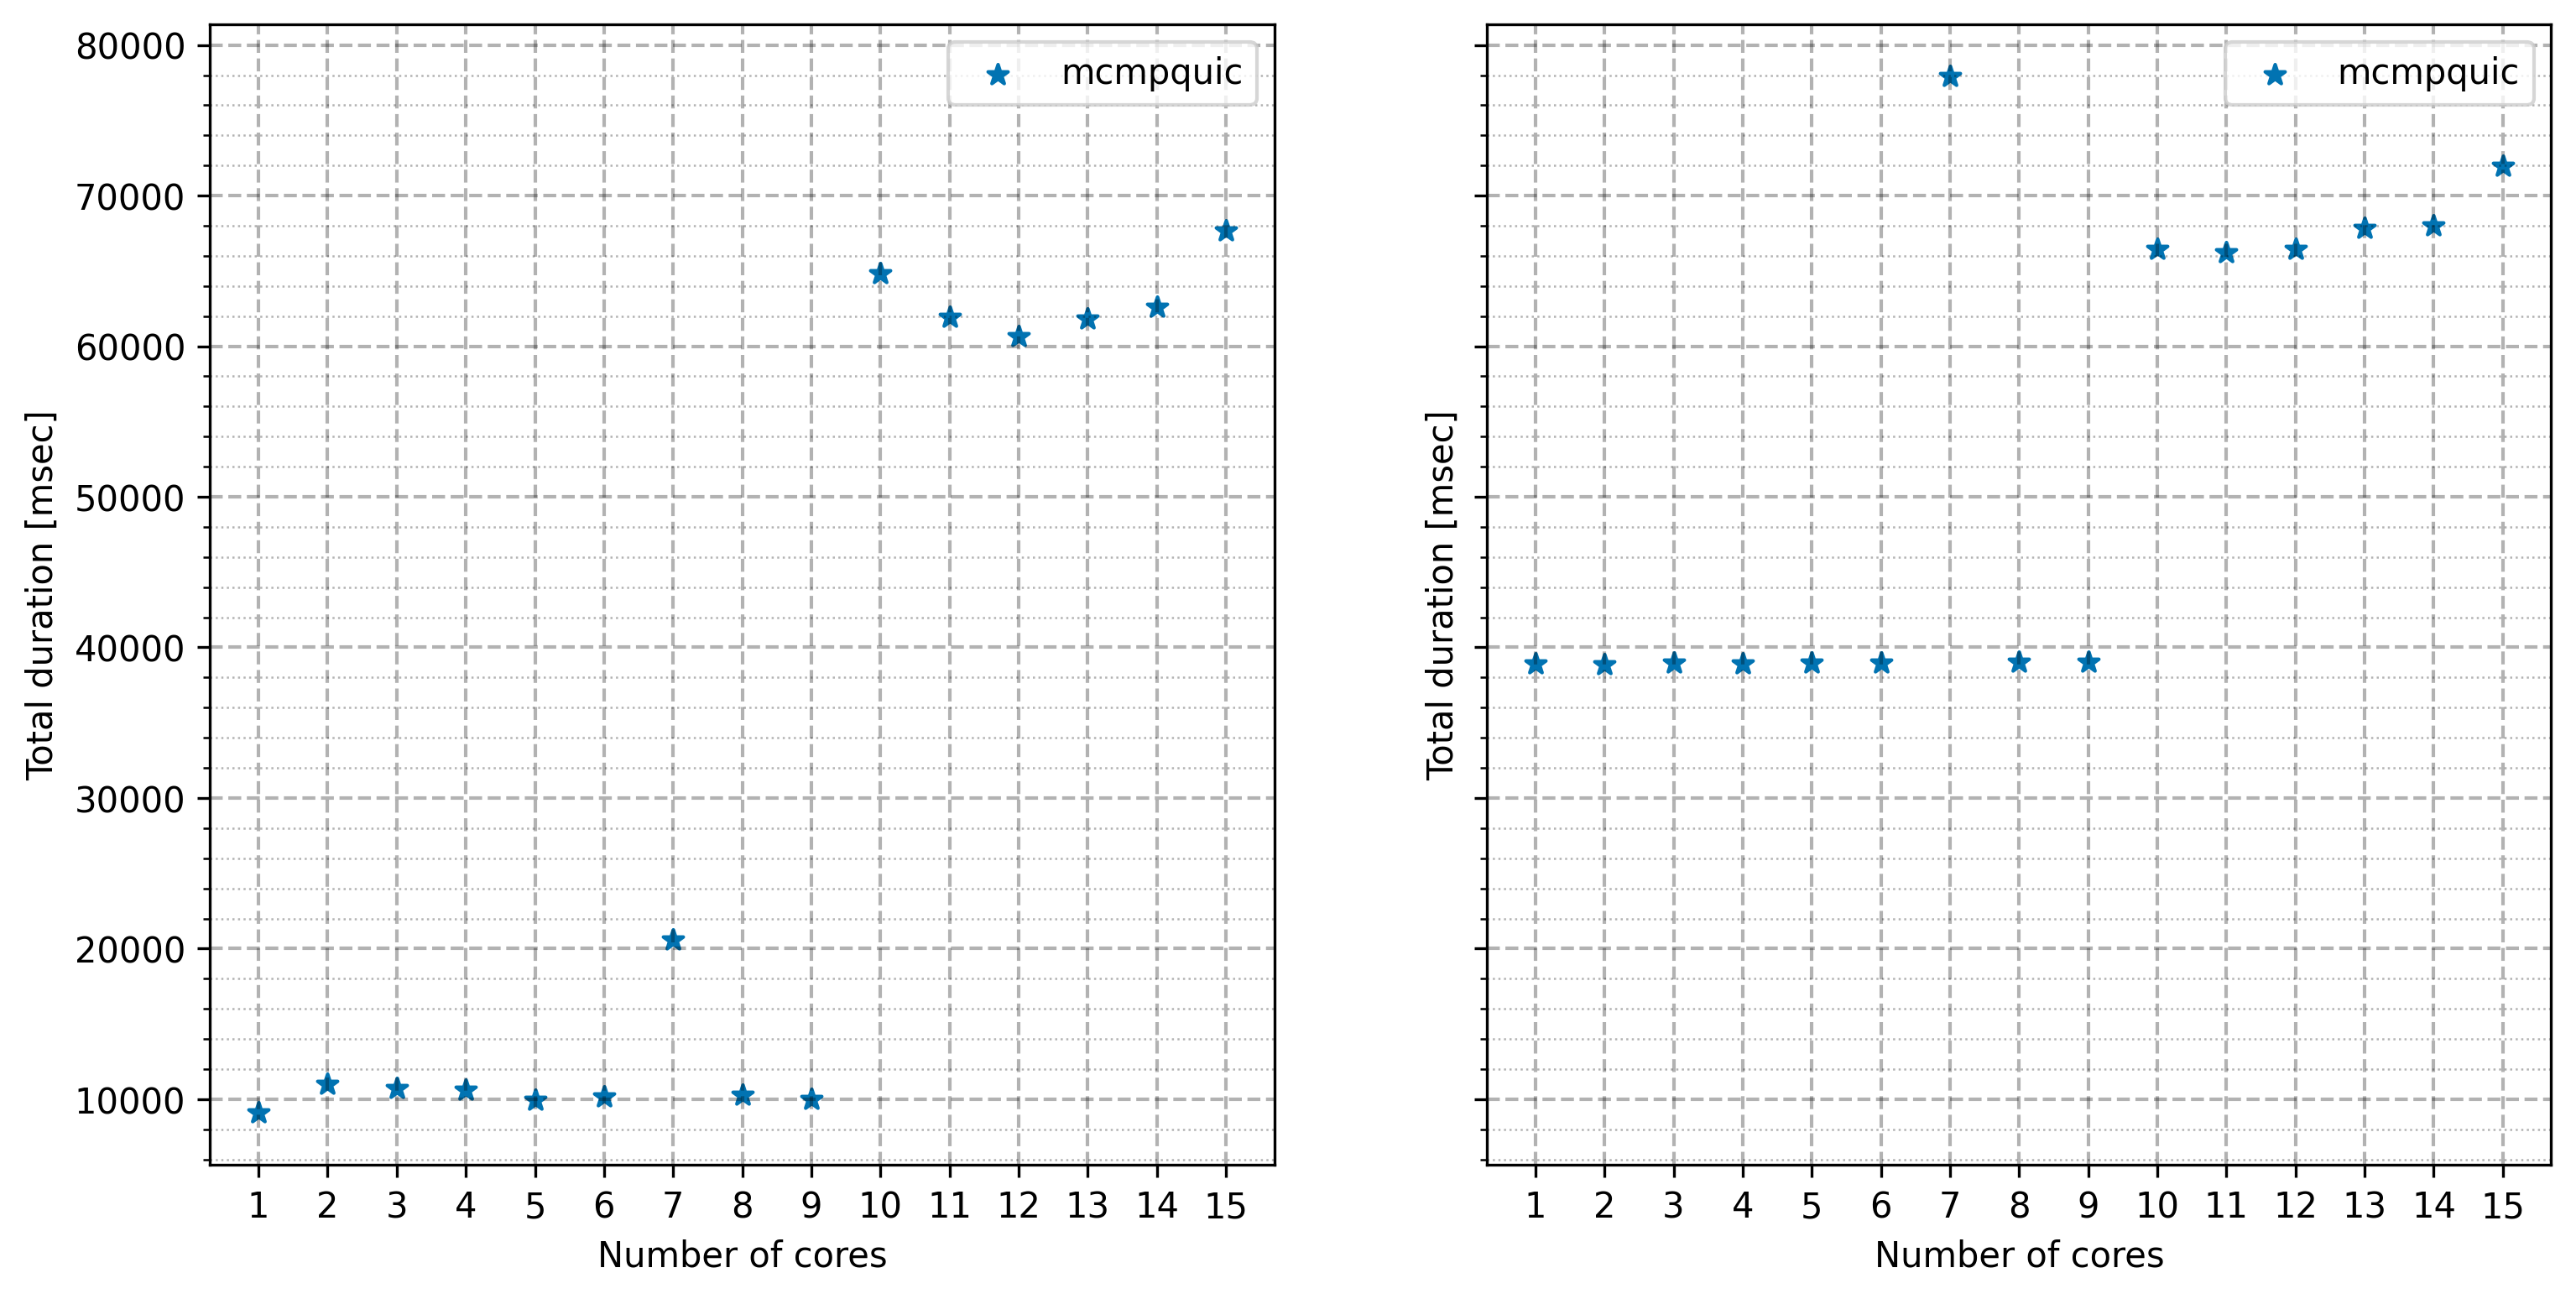

In [109]:
plot_total_syscall_per_core(df)

In [110]:
def axe_plot_calls_per_core(ax: plt.Axes, df: pd.DataFrame, title: str):
    """
    plot the number of calls per core from df
    nb_cores | calls | implementation
    """
    implementations = sorted(list(df["implementation"].unique()), reverse=True)
    colors=["#0173B2", "#029E73", "#D55E00","#CC78BC", "#ECE133", "#56B4E9"]
    all_nb_cores = list(df["nb_cores"].unique())
    all_nb_cores.sort()
    all_nb_cores = np.array(all_nb_cores)
    next_index = 0
    max_observed = 0
    for implementation in implementations:
        df_impl = df[df["implementation"] == implementation]
        subboxplot_data = []
        for nb_cores in all_nb_cores:
            cpu_util_values = df_impl[df_impl["nb_cores"] == nb_cores]["calls"]
            cpu_util_values = cpu_util_values.to_numpy()
            subboxplot_data.append(cpu_util_values)
            if len(cpu_util_values) == 0: continue
            max_observed = max(max_observed, max(cpu_util_values))
        ax.scatter(all_nb_cores, subboxplot_data, label=implementation, color=colors[next_index], marker="*")
        next_index += 1
    
    ax.set_xticks(all_nb_cores, all_nb_cores)
    ax.set_xlabel("Number of cores")
    ax.set_ylabel("Number of calls")
    ax.grid(which='major', color='black', linewidth=1, alpha=0.3, linestyle="dashed") # Show the major grid
    ax.grid(which='minor', axis="y", color='black', linewidth=0.6, alpha=0.3, linestyle="dotted") # Show the major grid    
    ax.legend()
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.set_title(title)

def plot_calls_per_core(df: pd.DataFrame, title: str):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=DPI, sharey=True)
    fig.subplots_adjust(hspace=0.1)
    fig.suptitle(title)
    client_df = df.loc[df["role"] == "client"]
    client_df = client_df.drop(columns=["role"], axis=1)
    client_df = client_df.groupby(["nb_cores", "implementation"])["calls"].sum().reset_index()
    axe_plot_calls_per_core(axes[0], client_df, "client")
    
    server_df = df.loc[df["role"] == "server"]
    server_df = server_df.drop(columns=["role"], axis=1)
    server_df = server_df.groupby(["nb_cores", "implementation"])["calls"].sum().reset_index()
    axe_plot_calls_per_core(axes[1], server_df, "server")

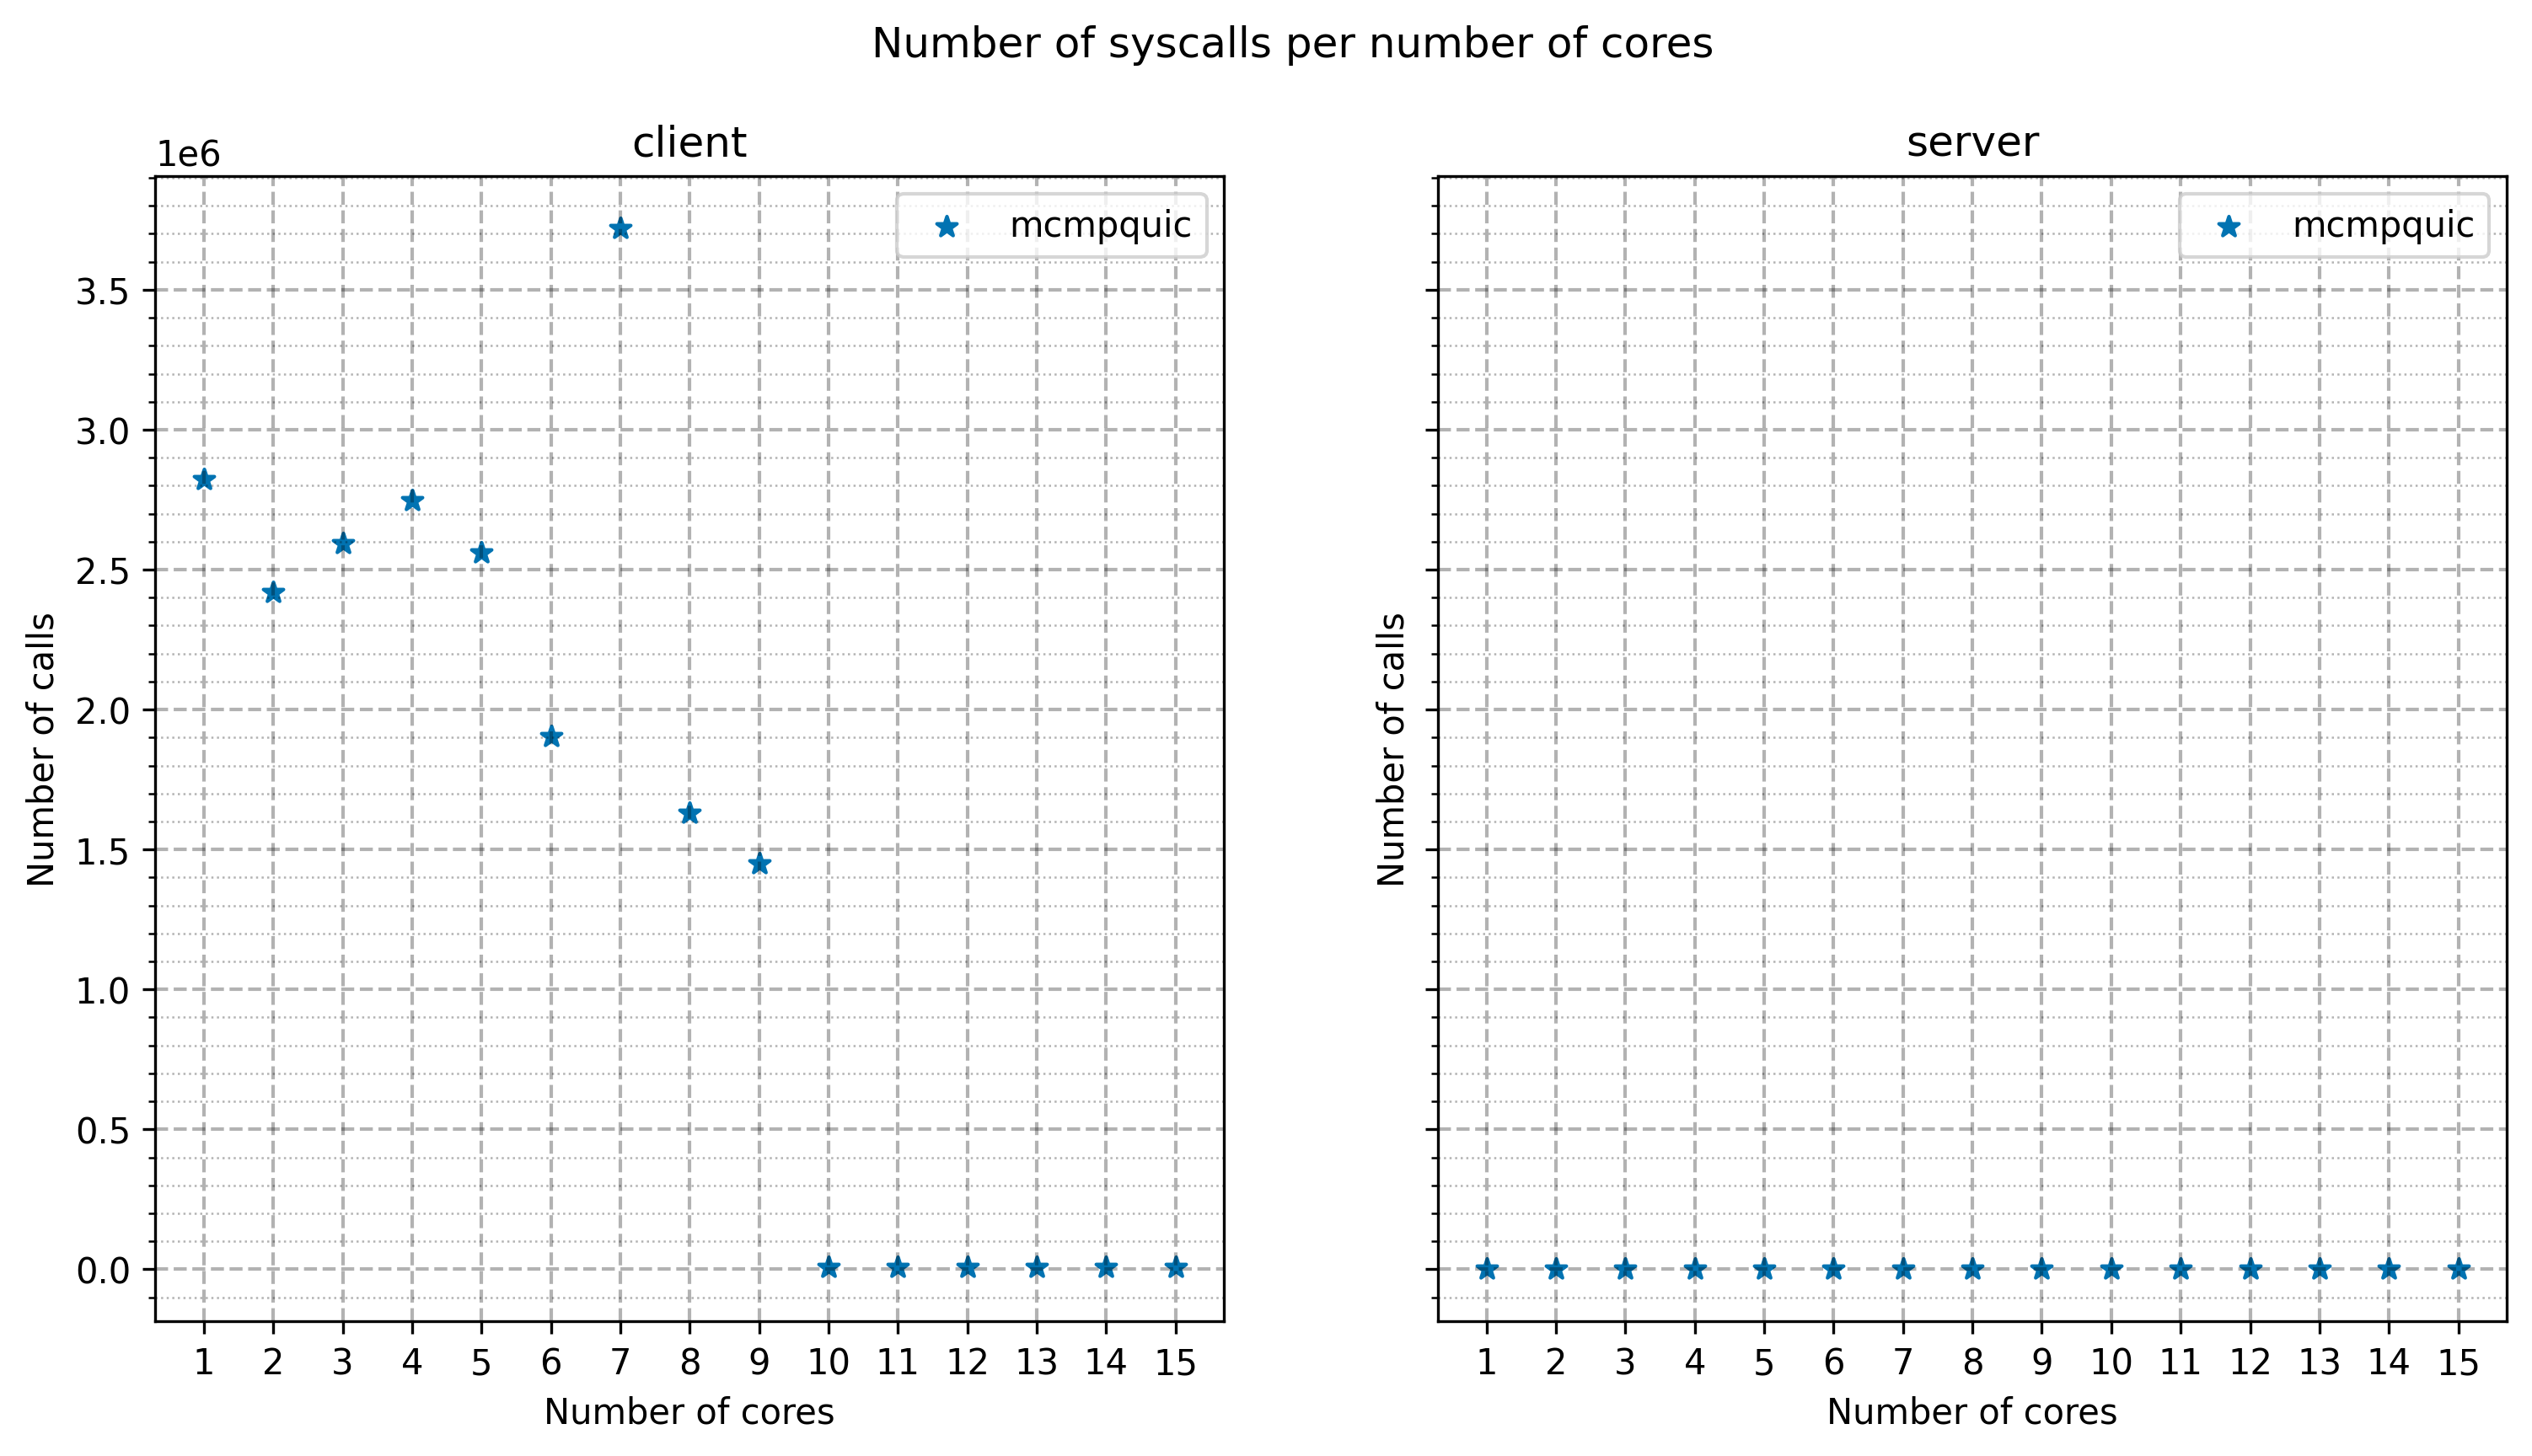

In [111]:
plot_calls_per_core(df, "Number of syscalls per number of cores")

In [112]:
def axe_plot_most_syscall_per_core(ax: plt.Axes, df: pd.DataFrame, title:str):
    implementations = sorted(list(df["implementation"].unique()), reverse=True)
    colors=["#0173B2", "#029E73", "#D55E00","#CC78BC", "#ECE133", "#56B4E9"]
    next_index = 0
    for implementation in implementations:
        df_impl = df[df["implementation"] == implementation]
        df_impl = df_impl.groupby(["syscall"])["calls"].sum().reset_index()
        df_impl = df_impl.sort_values(by=["calls"], ascending=False)
        ax.bar(df_impl["syscall"], df_impl["calls"], label=implementation, color=colors[next_index], zorder=3)
        next_index += 1
    ax.grid(which='major', color='black', linewidth=1, alpha=0.3, linestyle="dashed")
    ax.grid(which='minor', axis="y", color='black', linewidth=0.6, alpha=0.3, linestyle="dotted")
    ax.legend()
    ax.set_ylabel("Number of calls")
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
    
def plot_most_syscall_per_core(df: pd.DataFrame, title: str, top=8):
    """ plot the most called syscall per core
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=DPI, sharey=True)
    fig.suptitle(title)
    fig.subplots_adjust(hspace=0.1)
    client_df = df.loc[df["role"] == "client"]
    client_df = client_df.drop(columns=["role"], axis=1)
    client_df = client_df.groupby(["implementation", "syscall"])["calls"].sum().reset_index()
    client_df = client_df.sort_values(by=["calls"], ascending=False)
    client_df = client_df.groupby(["implementation"]).head(top)
    axe_plot_most_syscall_per_core(axes[0], client_df, "client")
    
    server_df = df.loc[df["role"] == "server"]
    server_df = server_df.drop(columns=["role"], axis=1)
    server_df = server_df.groupby(["implementation", "syscall"])["calls"].sum().reset_index()
    server_df = server_df.sort_values(by=["calls"], ascending=False)
    server_df = server_df.groupby(["implementation"]).head(top)
    axe_plot_most_syscall_per_core(axes[1], server_df, "server")
    
    plt.yscale("log")
    plt.ylim(1)
    

/tmp/ipykernel_21469/484588152.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
/tmp/ipykernel_21469/484588152.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


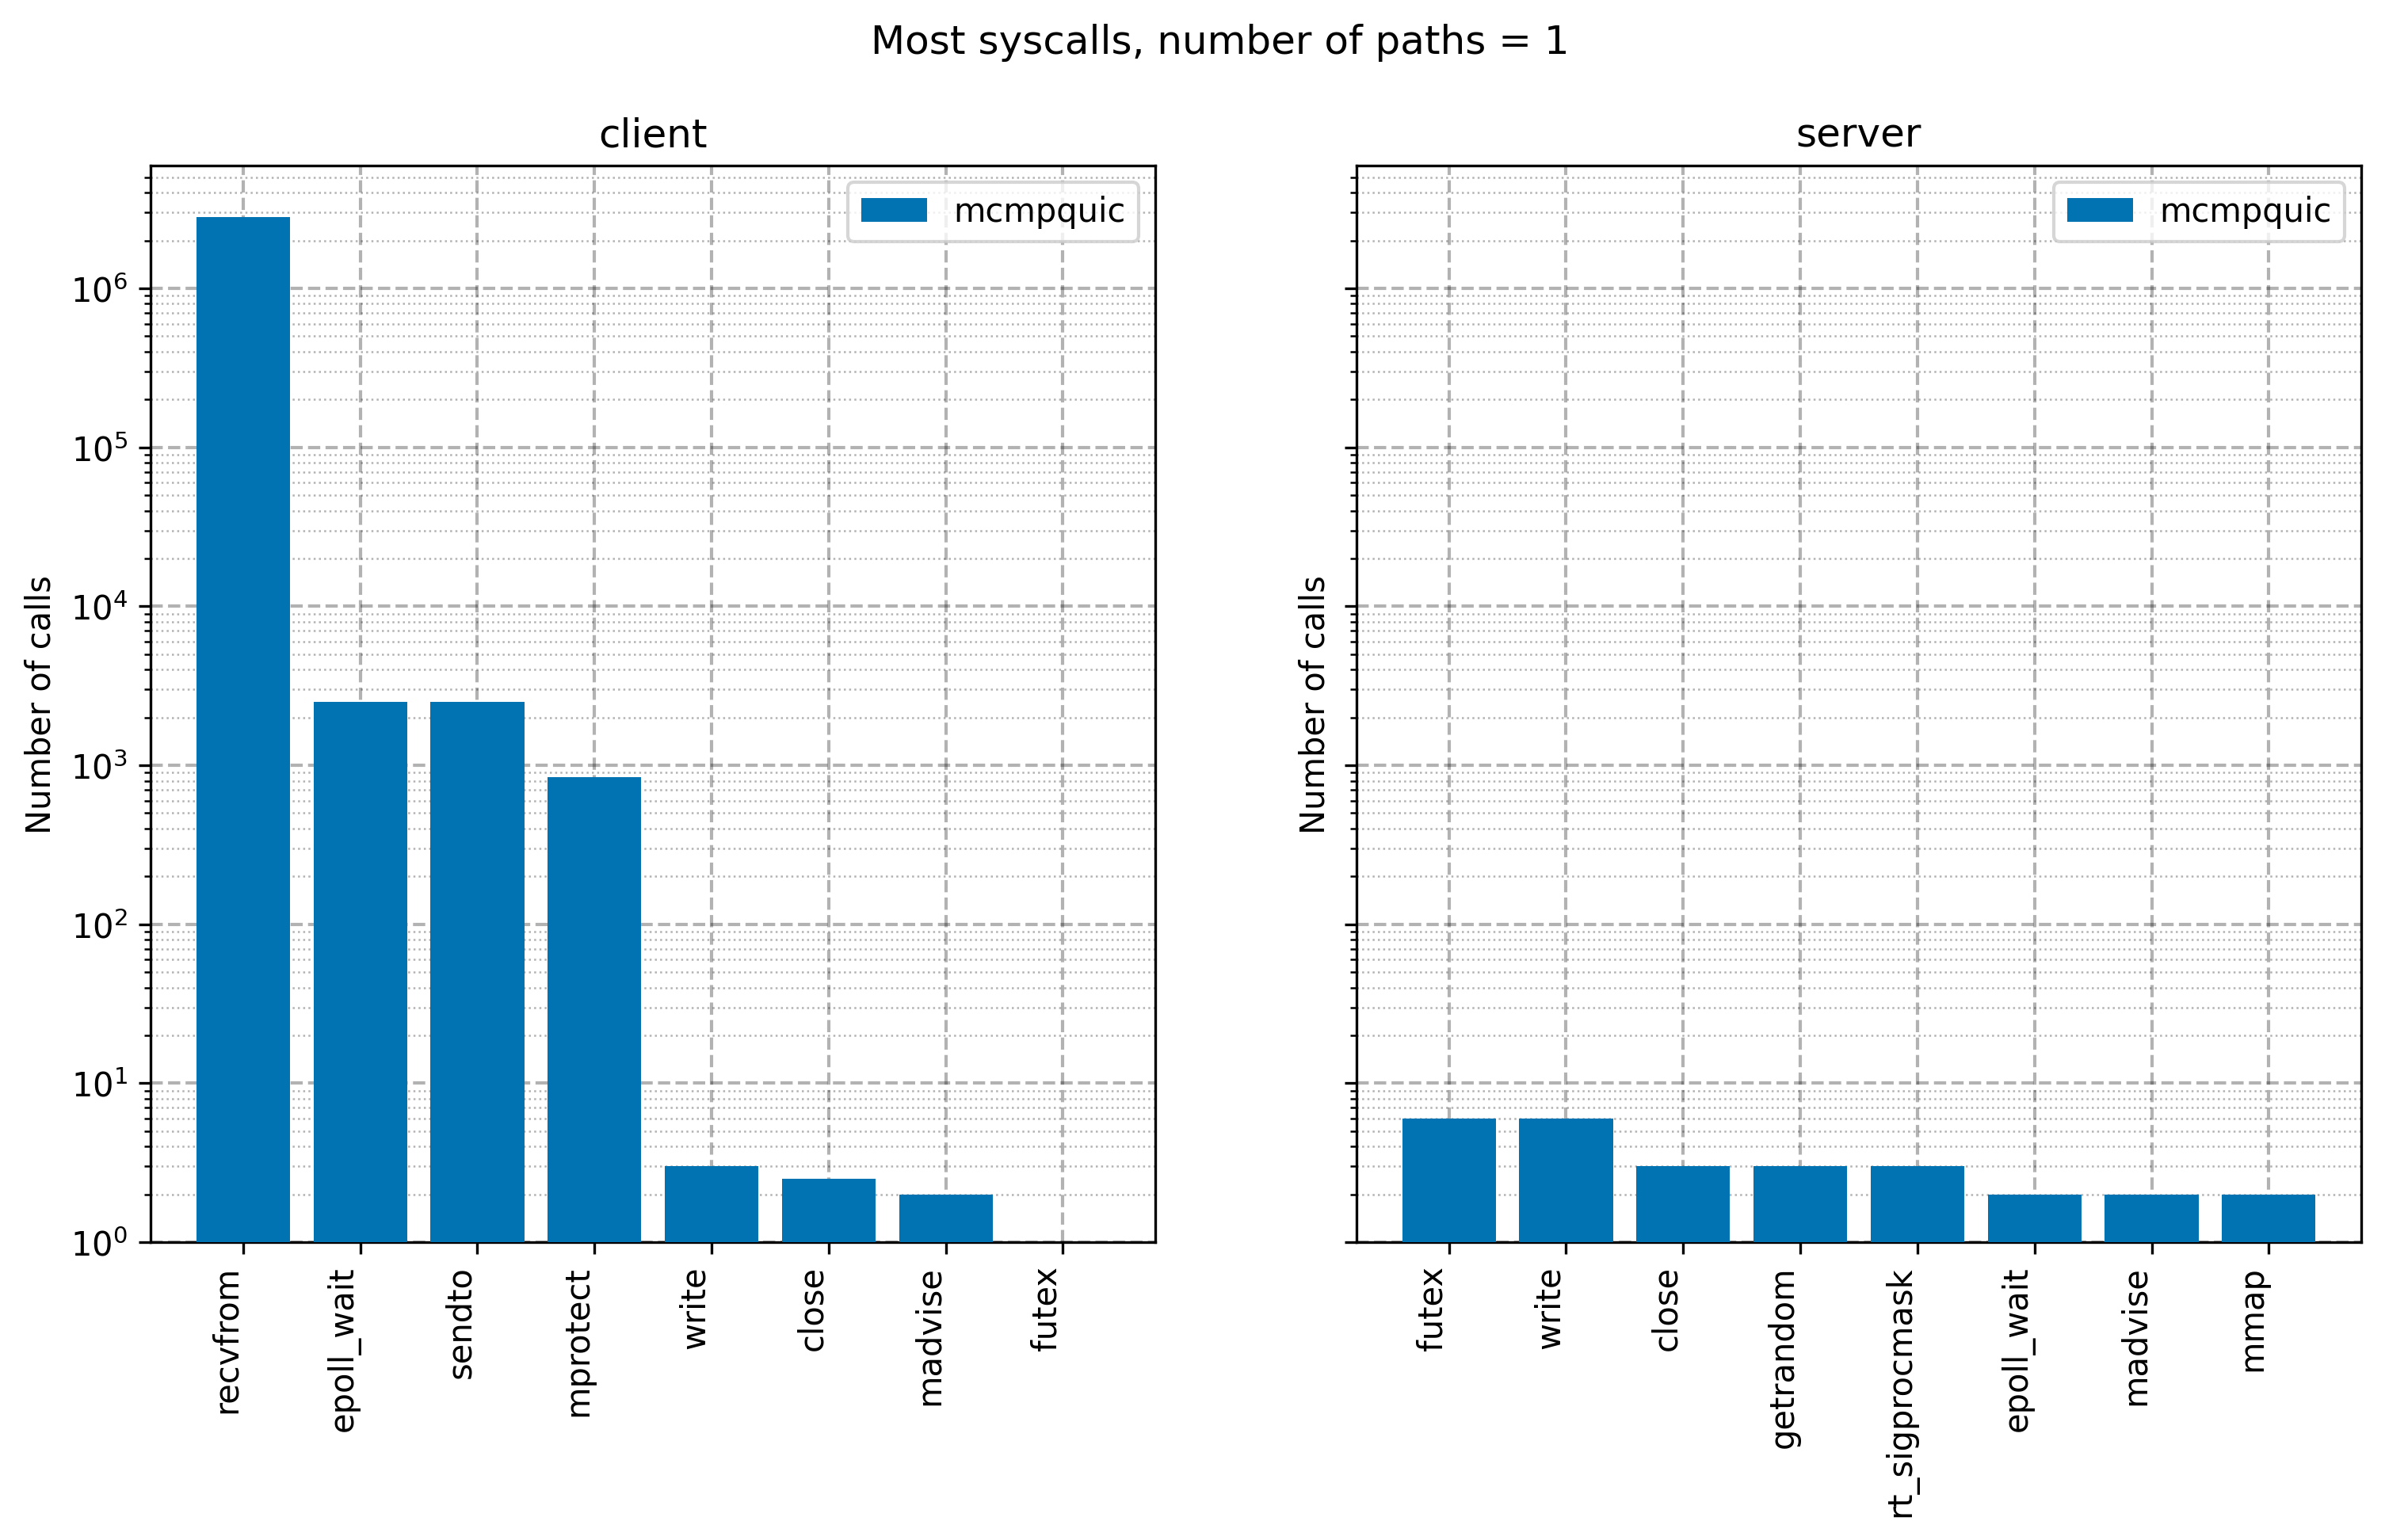

In [113]:
custom_df = df.loc[df["nb_cores"] == 1]
custom_df = custom_df.drop(columns=["nb_cores"], axis=1)
plot_most_syscall_per_core(custom_df, "Most syscalls, number of paths = 1")
plt.savefig(os.path.join(plots_directory, "most_syscalls_nb_paths_1.svg"), dpi=DPI, format="svg", bbox_inches="tight")

/tmp/ipykernel_21469/484588152.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
/tmp/ipykernel_21469/484588152.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


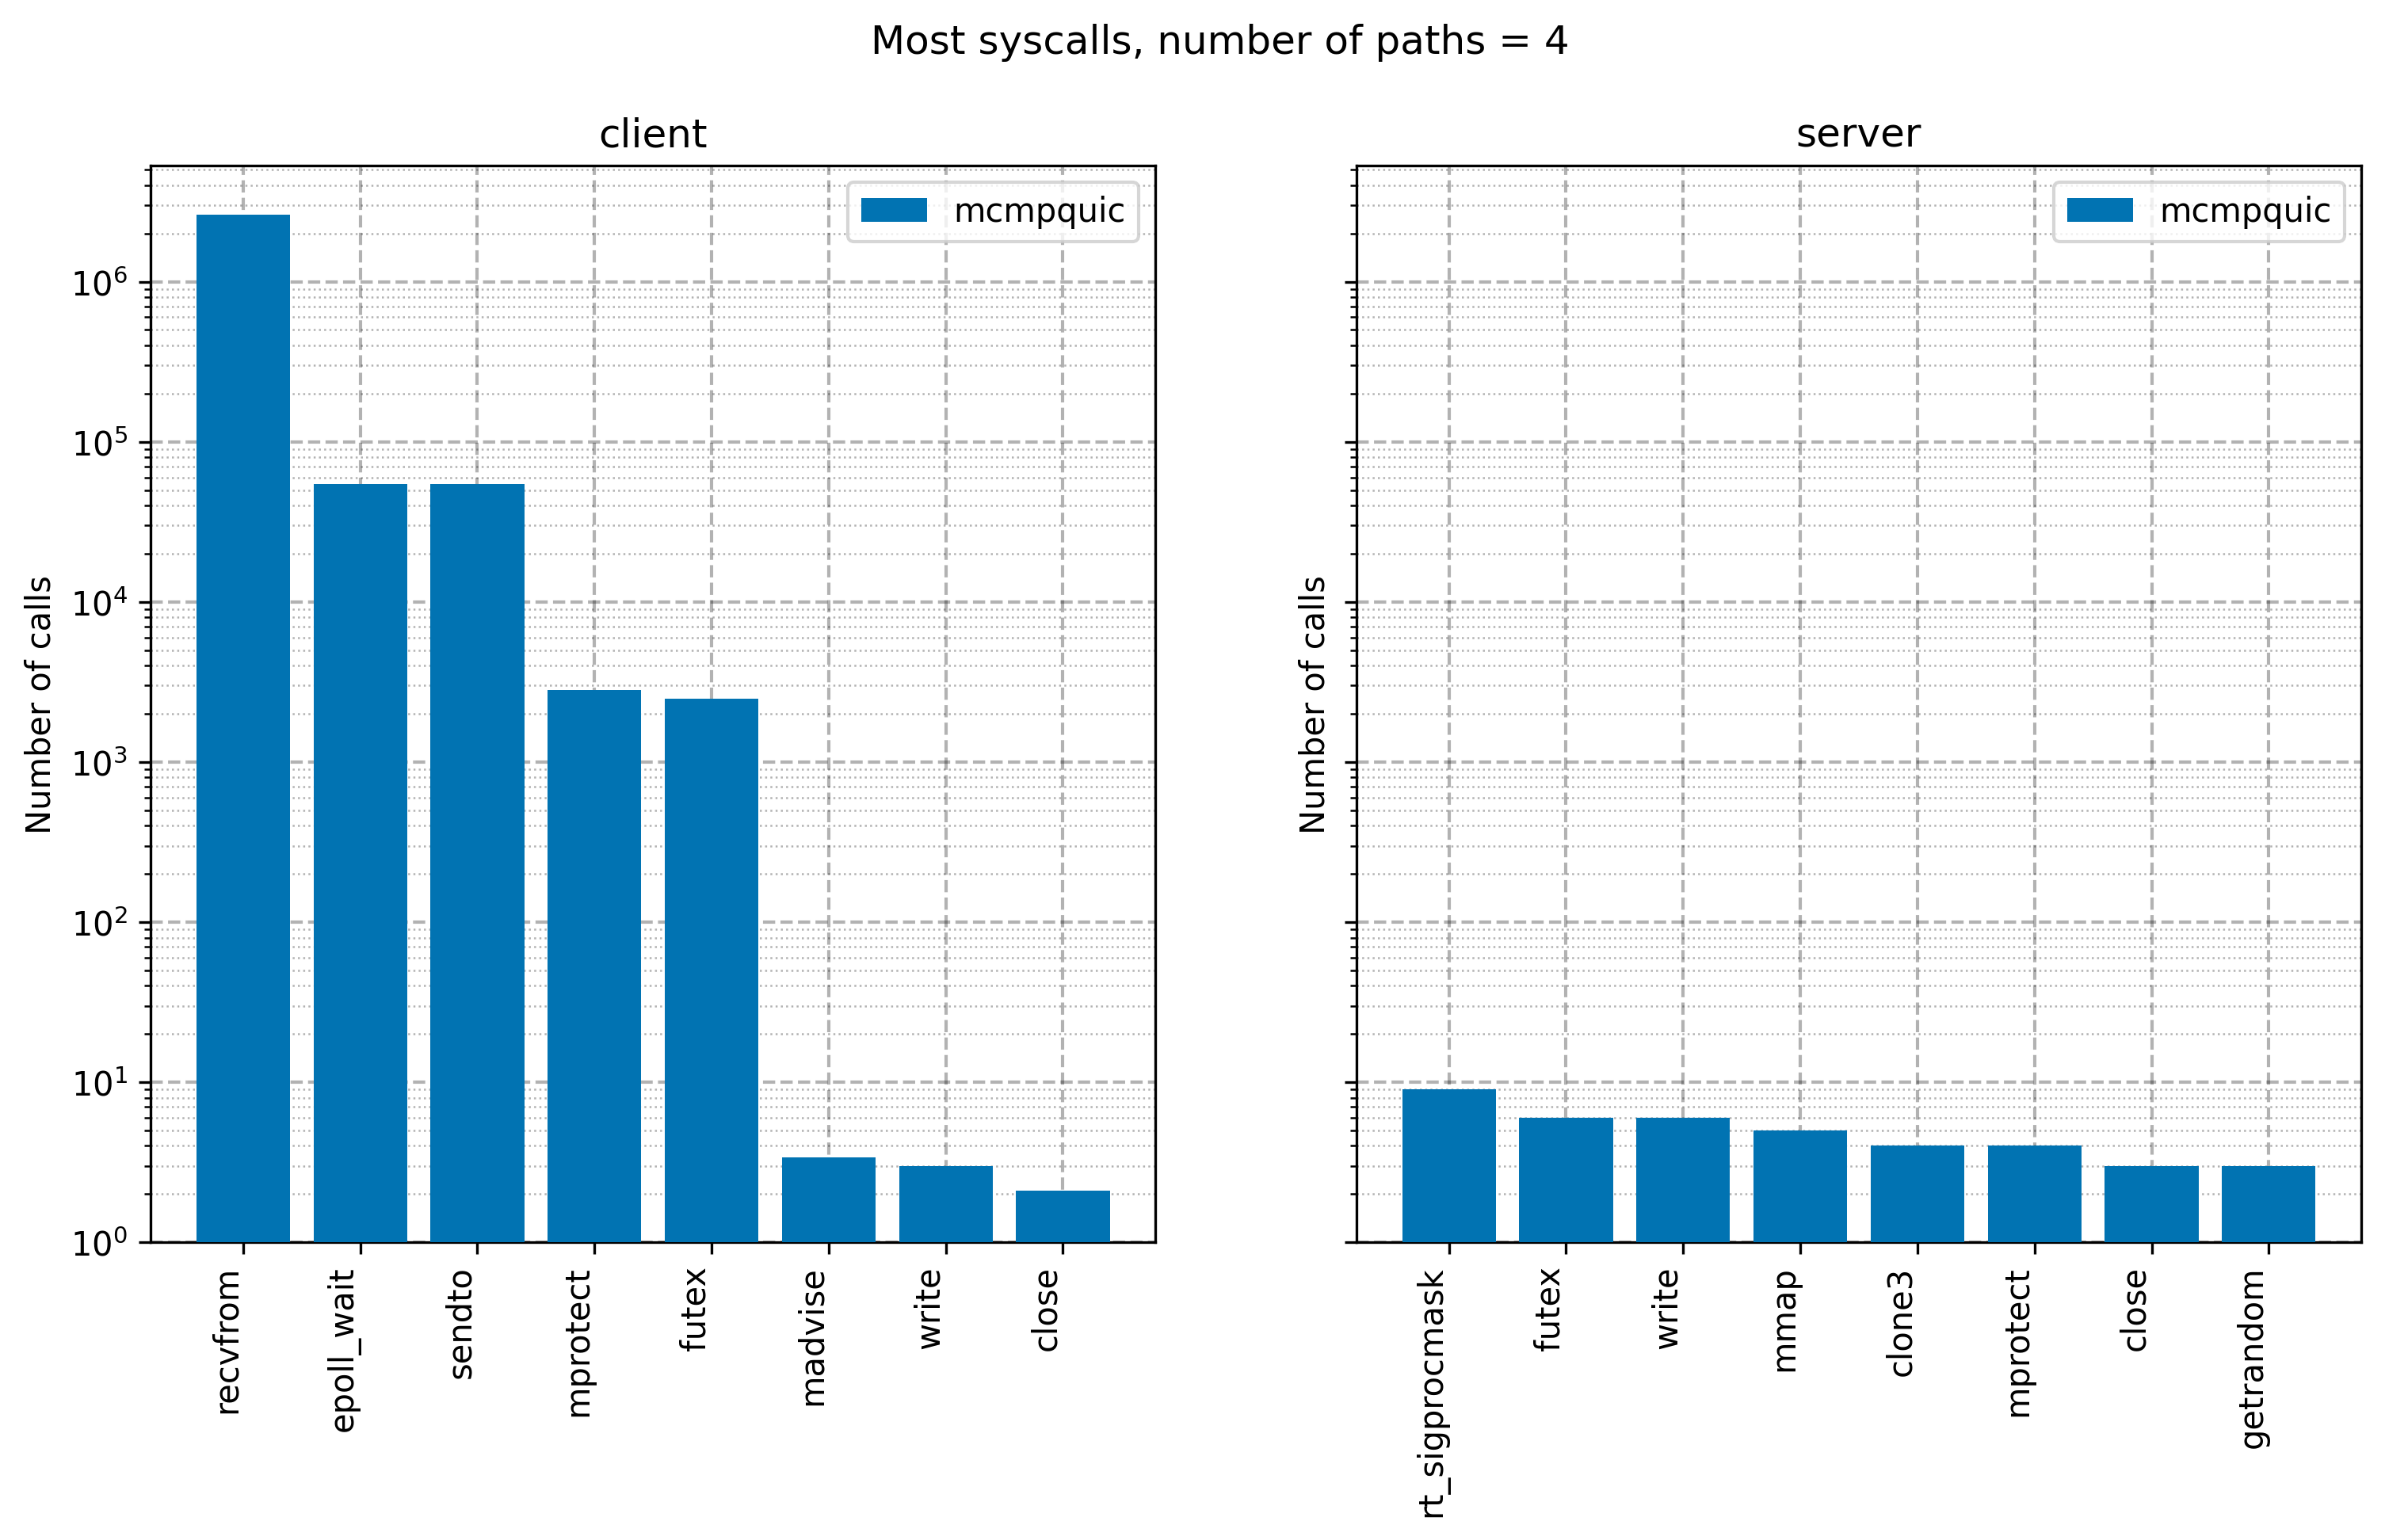

In [114]:
custom_df = df.loc[df["nb_cores"] == 4]
custom_df = custom_df.drop(columns=["nb_cores"], axis=1)
plot_most_syscall_per_core(custom_df, "Most syscalls, number of paths = 4")
plt.savefig(os.path.join(plots_directory, "most_syscalls_nb_paths_4.svg"), dpi=DPI, format="svg", bbox_inches="tight")

/tmp/ipykernel_21469/484588152.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
/tmp/ipykernel_21469/484588152.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


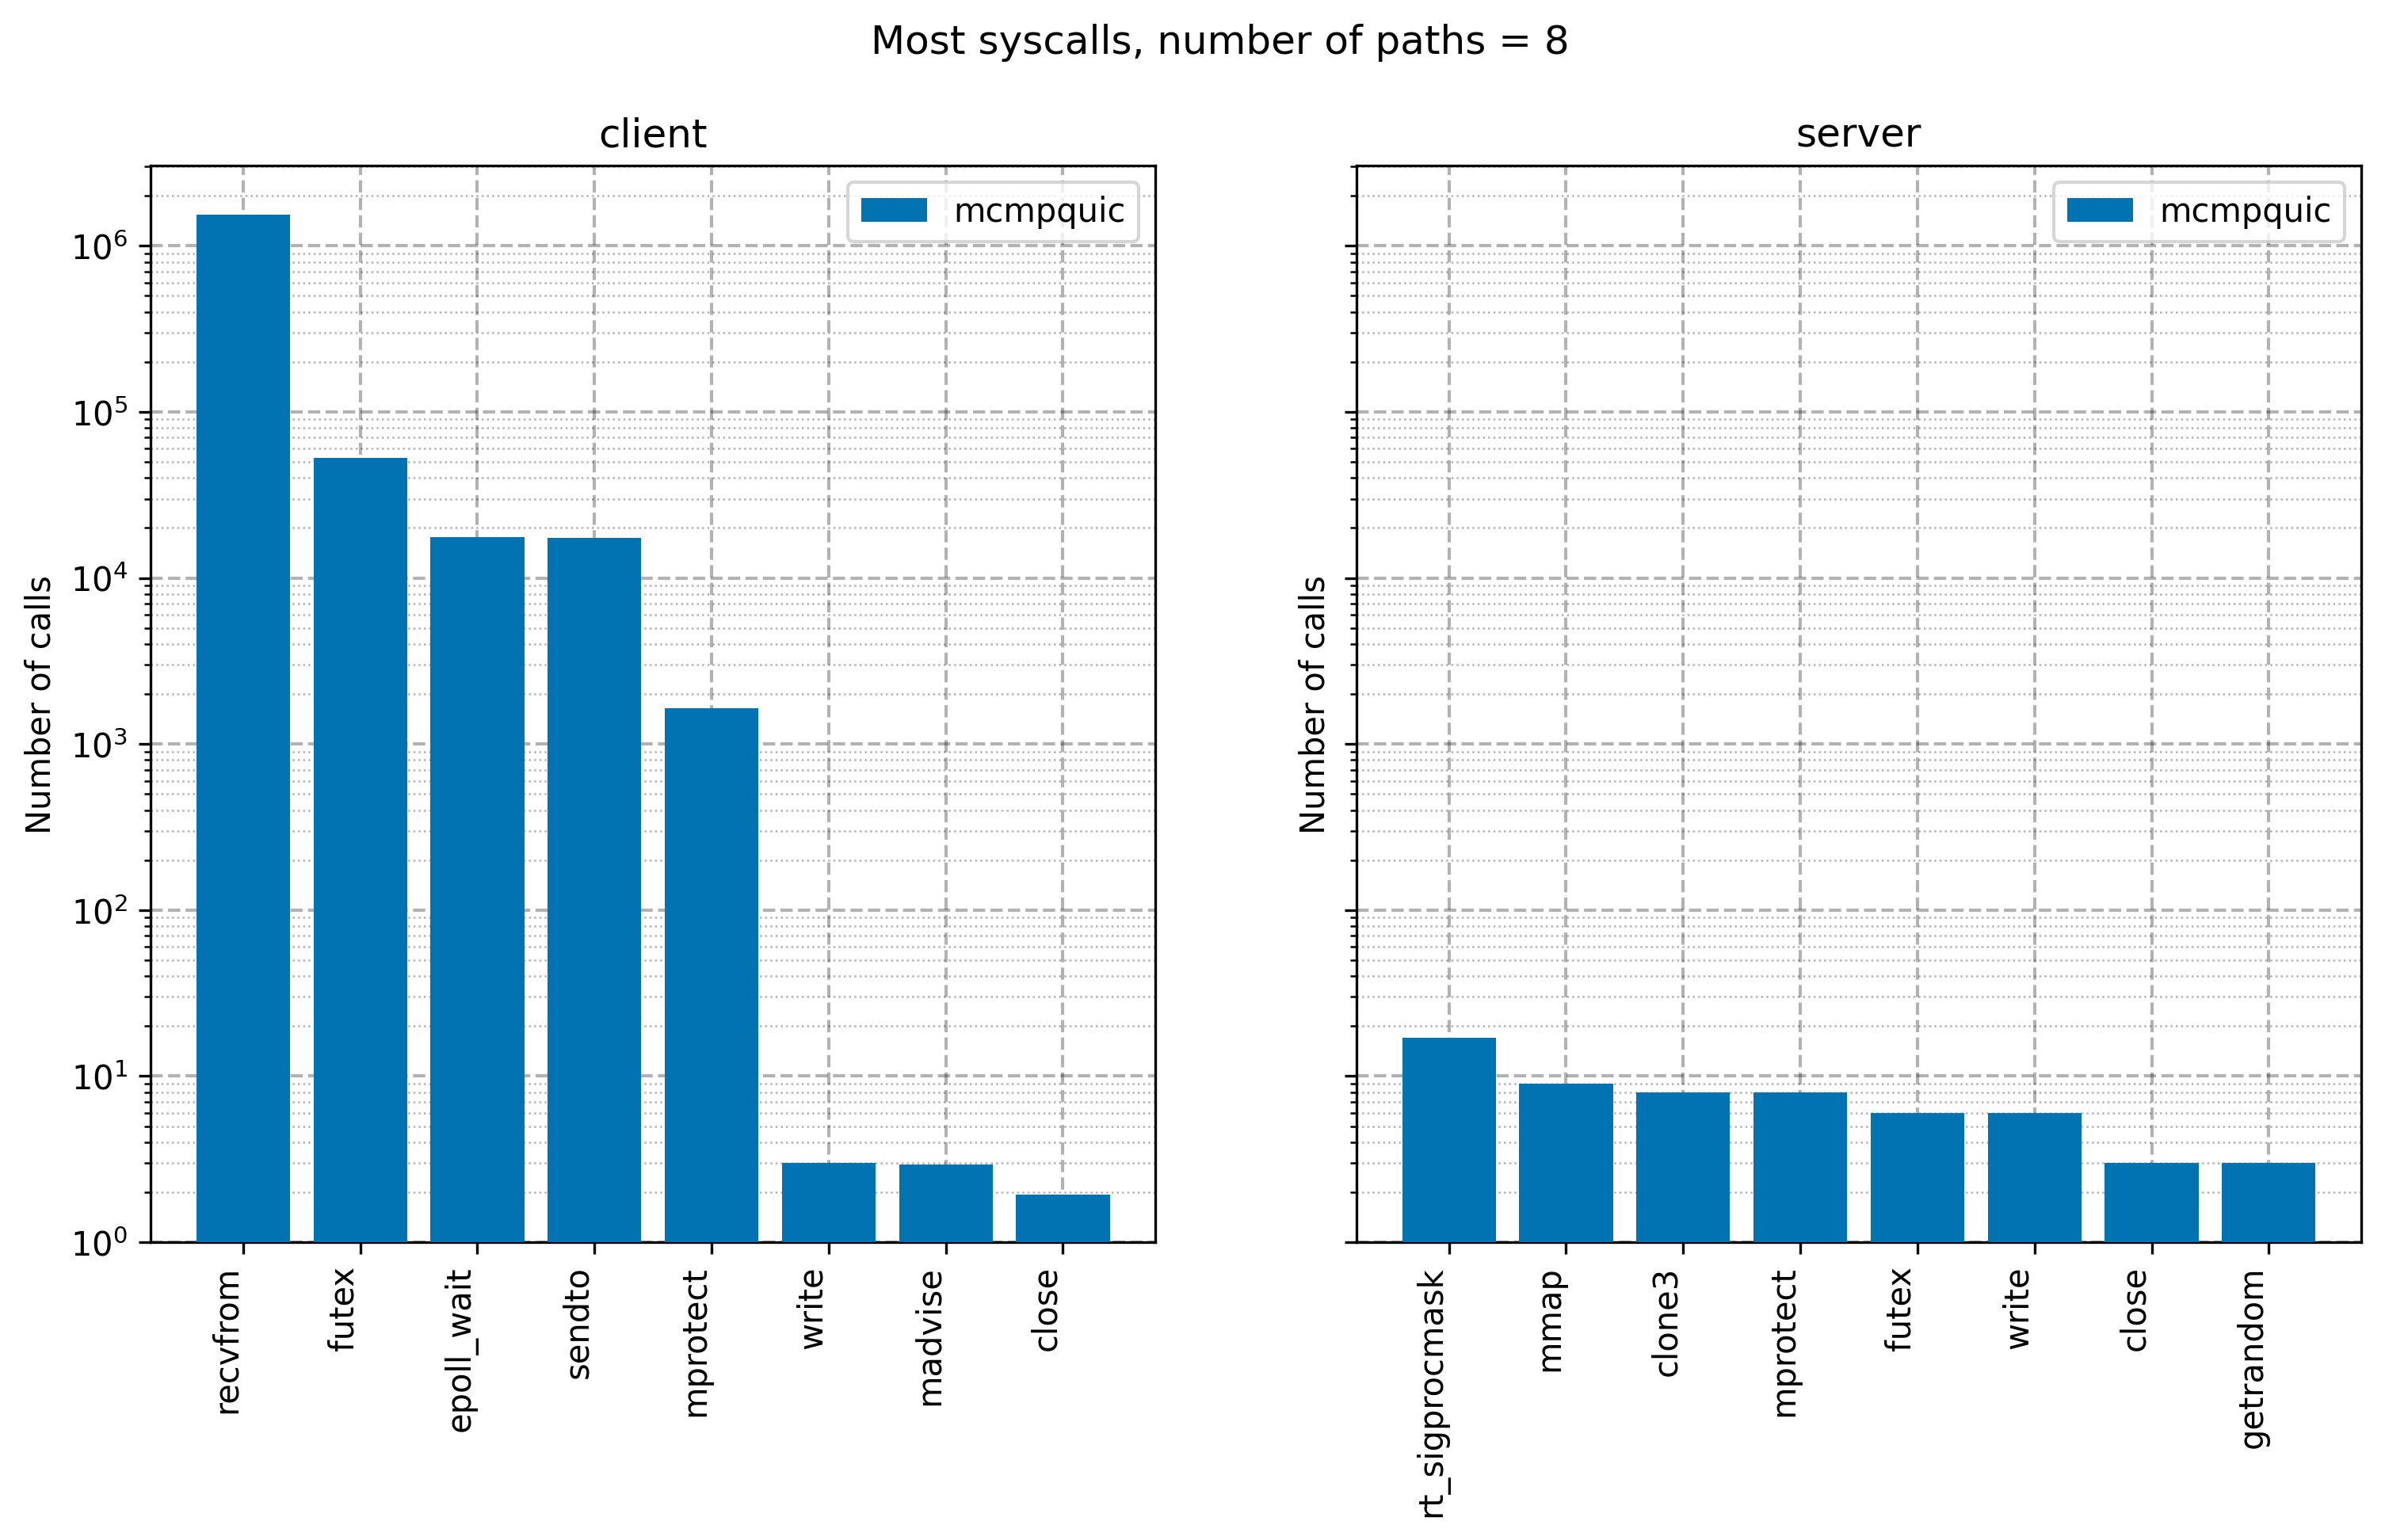

In [115]:
custom_df = df.loc[df["nb_cores"] == 8]
custom_df = custom_df.drop(columns=["nb_cores"], axis=1)
plot_most_syscall_per_core(custom_df, "Most syscalls, number of paths = 8")
plt.savefig(os.path.join(plots_directory, "most_syscalls_nb_paths_8.svg"), dpi=DPI, format="svg", bbox_inches="tight")

/tmp/ipykernel_21469/484588152.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
/tmp/ipykernel_21469/484588152.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


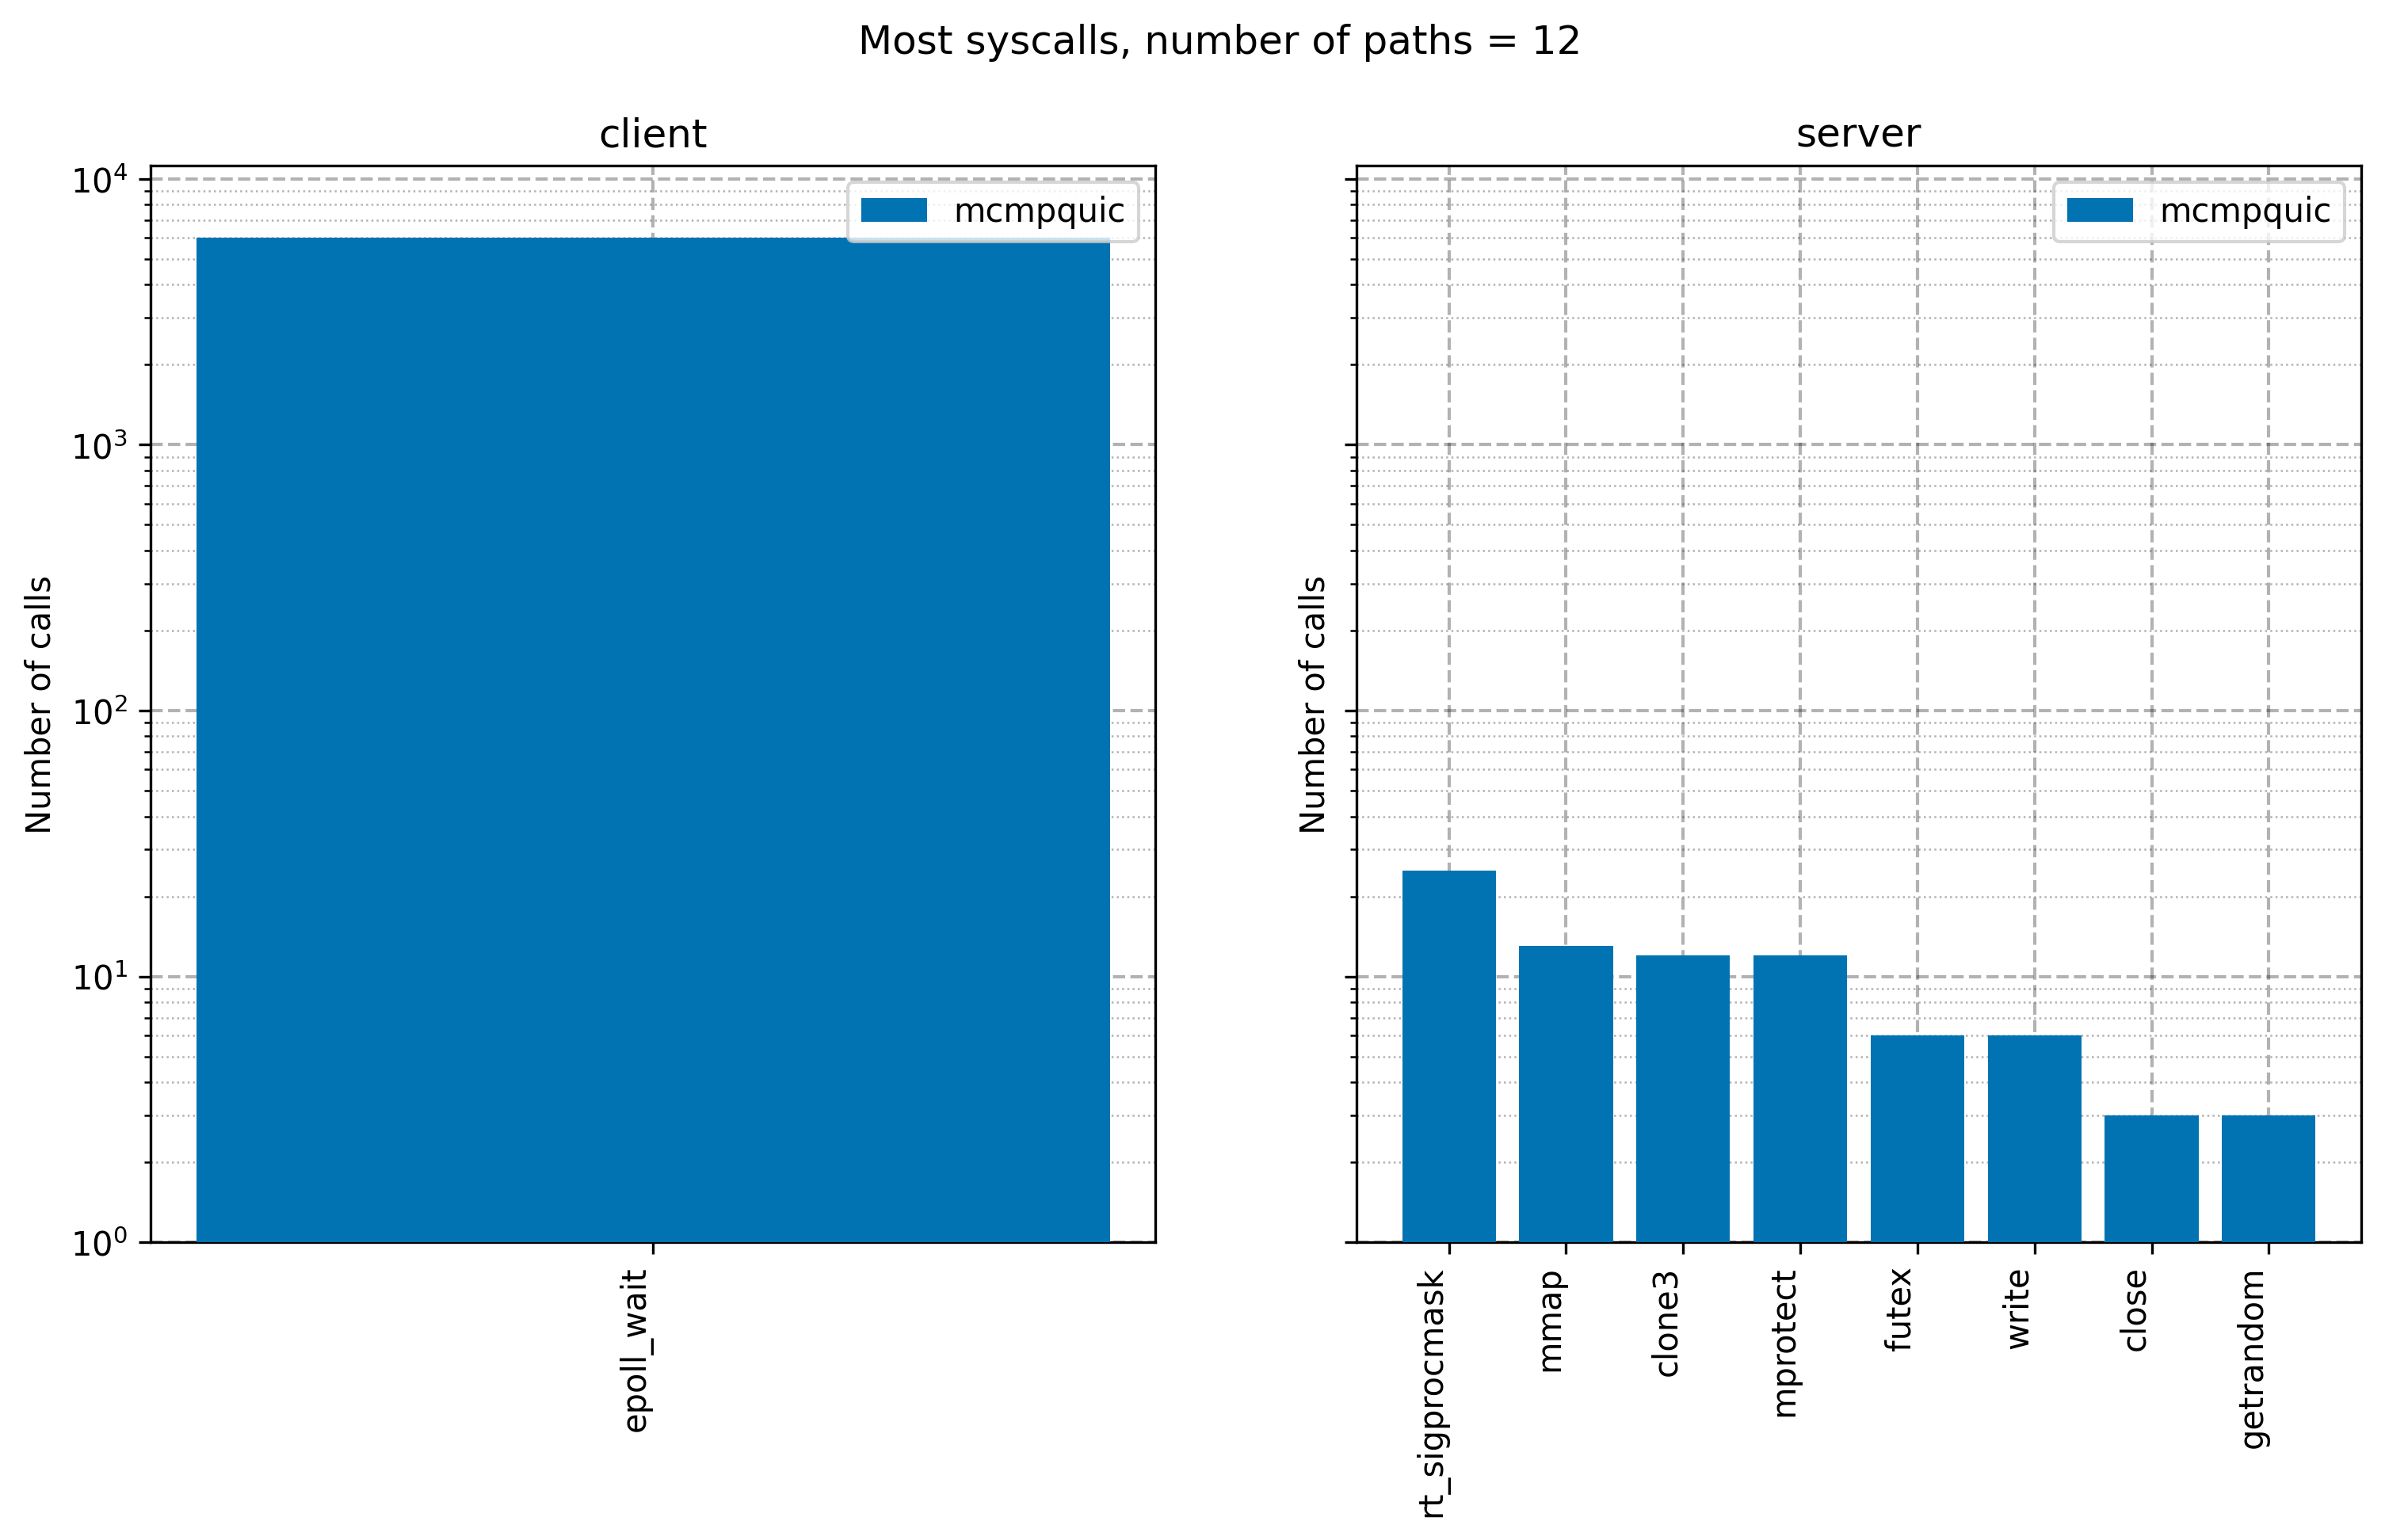

In [116]:
custom_df = df.loc[df["nb_cores"] == 12]
custom_df = custom_df.drop(columns=["nb_cores"], axis=1)
plot_most_syscall_per_core(custom_df, "Most syscalls, number of paths = 12")
plt.savefig(os.path.join(plots_directory, "most_syscalls_nb_paths_12.svg"), dpi=DPI, format="svg", bbox_inches="tight")